In [1]:
import numpy as np
import matplotlib.pyplot as plt
import function as func
import csv

import math

8.817994782658312e-11
2.4559385718827572e-11


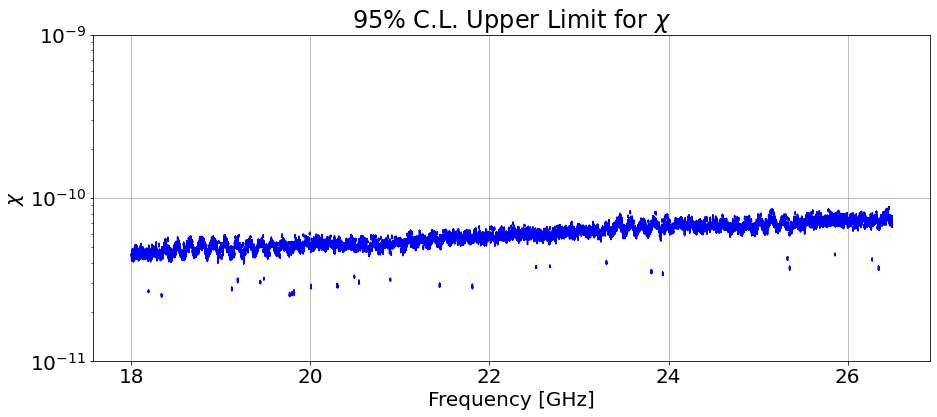

In [6]:
plt.figure(figsize=(15,6))
plt.rcParams["font.size"] = 20
#fig.suptitle("Result of Exp.1 ~ Exp.4")

check_freq = np.array([18190, 18336, 19120, 19186, 19440, 19478, 19766, 19794, 19818, 20006, 20296, 20302, 20490, 20540, 20892, 21442, 21808, 22522, 22672, 23306, 23808, 23934, 25328, 25352, 25860, 26274, 26346])
check_freq = check_freq*1000 - 250

A_geom = np.pi * (59.3/2*1e-3)**2
eta = 0.63

def eta_win(freq):
    return 0.23 + 0.017 * (freq - 22)

val_max = 0.
val_min = 1.
"""
out_path = "/data/ms2840a/result_data/chi_limit_final.csv"
with open(out_path, "w") as f:
    writer = csv.writer(f)
    writer.writerow(["freq", "chi"])
"""


for i in range(180, 265, 1):
    start_freq = i/10
    initial = int(start_freq * 1.e+6 - 250)
    final = int(initial + 1.e+5)

    for j in range(initial, final, 2000):
        word = list(str(j))
        word.insert(2, ".")
        start = "".join(word)
        
        val = 0
        if float(start)*1e6 in check_freq:
            path = "/data/ms2840a/result_data/check_result/fit_result/start_{}GHz.csv".format(start)
            data = func.csv_to_array(path)
            val = np.max(data["P"],0) + 1.71*data["P_err"]
        else:
            path = "/data/ms2840a/result_data/fit_result/start_{}GHz.csv".format(start)
            data = func.csv_to_array(path)
            val = np.max(data["P"],0) + 1.71*data["P_err"]
                     
        # Upper limit on P_DP (val) --> Upper limit on Chi + syst. uncertaintis (1.103) 
        chi = 1.103 * 1.4e-10 * (val * eta_win(data["freq_0"]/1e9) / 1e-19)**0.5 * (1e-3 / (A_geom*eta))**0.5
        plt.plot(data["freq_0"]/1e9, chi, color="blue")
        val_max = max(val_max, np.max(chi))
        val_min = min(val_min, np.min(chi))


"""
with open(out_path, "a") as f:
    writer = csv.writer(f)
    for k in range(len(chi)):
        writer.writerow([data["freq_0"][k]/1e9, chi[k]])
"""

#data = func.csv_to_array("/data/ms2840a/result_data/chi_limit_final.csv")
#plt.plot(data["freq"], data["chi"], color="blue")
plt.grid()
plt.yscale("log")
plt.title(r"95% C.L. Upper Limit for $\chi$")
plt.ylabel(r"$\chi$")
plt.xlabel("Frequency [GHz]")
plt.ylim([1e-11, 1e-9])

print(val_max)
print(val_min)
                    
plt.savefig("../result_figure/fit_result/limit_chi.pdf")

In [30]:
print(eta*A_geom)

0.0017399622161914604


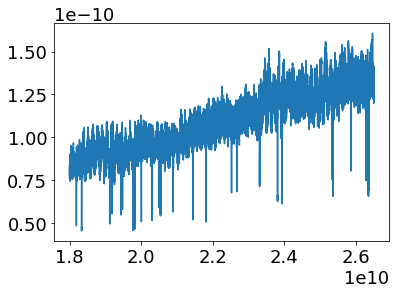

In [30]:
data = func.csv_to_array("/data/ms2840a/result_data/chi_limit.csv")
plt.plot(data["freq[Hz]"], data["chi"])

In [25]:
A_geom*eta

0.0009114087799098127

In [28]:
def plot_add_spec(ax, num):
    

    check_freq = np.array([18190, 18336, 19120, 19186, 19440, 19478, 19766, 19794, 19818, 20006, 20296, 20302, 20490, 20540, 20892, 21442, 21808, 22522, 22672, 23306, 23808, 23934, 25328, 25352, 25860, 26274, 26346])

    line = np.array([
        18.190812,
        18.336724,
        19.120514,
        19.187772,
        19.441606,
        19.479506,
        19.766974,
        19.794366,
        19.819072,
        20.007980,
        20.296620,
        20.302788,
        20.490250,
        20.541586,
        20.893242,
        21.443168,
        21.808598,
        22.522234,
        22.673946,
        23.307606,
        23.808666,
        23.935386,
        25.329956,
        25.353898,
        25.860092,
        26.274234,
        26.347692])
    
    word = list(str(check_freq[num]*1000 - 250))
    word.insert(2, ".")
    start = "".join(word)

    path = "/data/ms2840a/result_data/check_result/signal_p_local_mean_fit/start_{}GHz.csv".format(start)
    data1 = func.csv_to_array(path)

    ax.plot((data1["freq_0"]/1e+9 - np.floor(line[num]*100)/100)*1e3, data1["p_local"], color="blue")
    ax.axvline(x = (line[num] - np.floor(line[num]*100)/100)*1e3, color="red", linestyle='--')
    ax.grid()
    ax.set_yscale("log")
    ax.set_xlabel("Frequency [MHz + {} GHz]".format(np.floor(line[num]*100)/100))
    ax.set_ylabel(r"$p_{\rm local}$")
    ax.set_ylim([5e-6, 2])
    ax.set_yticks([1, 1e-1, 1e-2, 1e-3, 1e-4, 1e-5])
    
    title = ""
    if num+1 == 1 or num+1 == 11 or num+1 == 21: title = str(num+1) + "st"
    elif num+1 == 2 or num+1 == 12 or num+1 == 22: title = str(num+1) + "nd"
    elif num+1 == 3 or num+1 == 13: title = str(num+1) + "rd"
    else: title = str(num+1) + "th"
    ax.set_title(title + r": $\nu_0 = {} ~\rm GHz$".format(line[num]))

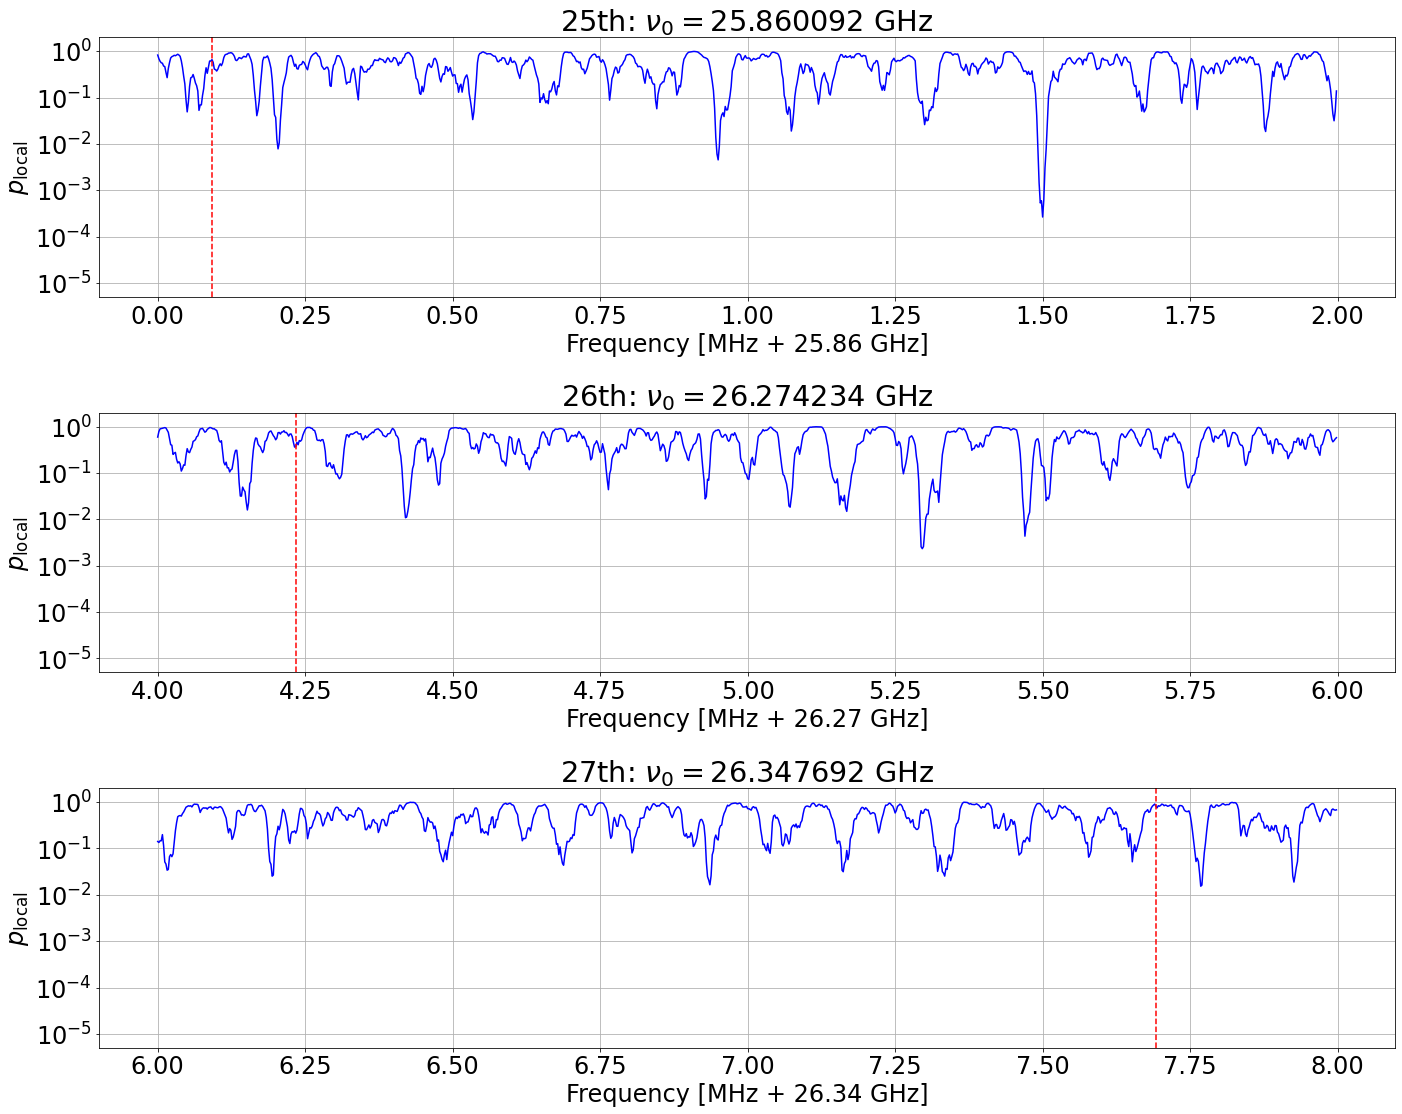

In [34]:
fig, axes = plt.subplots(3,1,figsize=(20,16), squeeze=False)
plt.rcParams["font.size"] = 24

for i in range(3):
    plot_add_spec(axes[i][0], i+24)
                    
fig.tight_layout()

plt.savefig("../result_figure/under_1e5/from25to27_add.pdf")

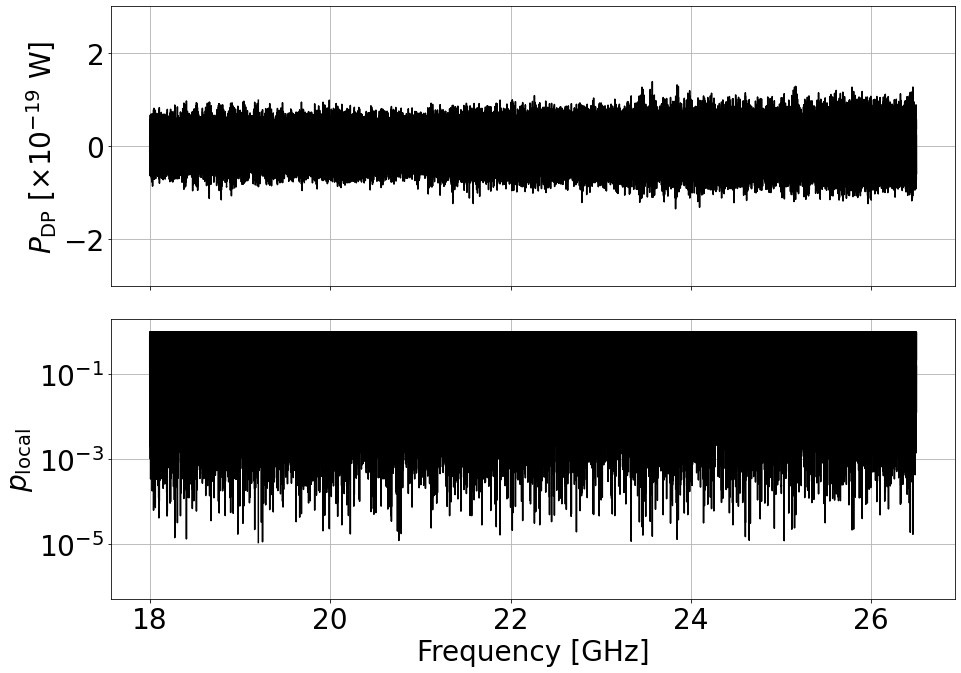

In [10]:
plt.rcParams["font.size"] = 28
fig, axes = plt.subplots(2,1,figsize=(14,10), squeeze=False, sharex=True)

check_freq = np.array([18190, 18336, 19120, 19186, 19440, 19478, 19766, 19794, 19818, 20006, 20296, 20302, 20490, 20540, 20892, 21442, 21808, 22522, 22672, 23306, 23808, 23934, 25328, 25352, 25860, 26274, 26346])
check_freq = check_freq*1000 - 250

for i in range(180, 265, 1):
    start_freq = i/10
    initial = int(start_freq * 1.e+6 - 250)
    final = int(initial + 1.e+5)

    for j in range(initial, final, 2000):
        word = list(str(j))
        word.insert(2, ".")
        start = "".join(word)

        if float(start)*1e6 in check_freq:
            # P_DP
            path = "/data/ms2840a/result_data/check_result/fit_result/start_{}GHz.csv".format(start)
            data = func.csv_to_array(path)
            axes[0][0].plot(data["freq_0"]/1e9, data["P"]*1e19, color="black")
            
            # p_local before
            # path = "/data/ms2840a/result_data/signal_p_local/start_{}GHz.csv".format(start)
            # data = func.csv_to_array(path)
            # axes[1][0].plot(data["freq_0"]/1e9, data["p_local"], color="black")

            # p_local after
            path = "/data/ms2840a/result_data/check_result/signal_p_local_mean_W/start_{}GHz.csv".format(start)
            data = func.csv_to_array(path)
            axes[1][0].plot(data["freq_0"]/1e9, data["p_local"], color="black")
        else:
            # P_DP
            path = "/data/ms2840a/result_data/fit_result/start_{}GHz.csv".format(start)
            data = func.csv_to_array(path)
            axes[0][0].plot(data["freq_0"]/1e9, data["P"]*1e19, color="black")

            # p_local before
            path = "/data/ms2840a/result_data/signal_p_local/start_{}GHz.csv".format(start)
            data = func.csv_to_array(path)
            axes[1][0].plot(data["freq_0"]/1e9, data["p_local"], color="black")

        

ax = axes[0][0]
ax.grid()
ax.set_ylim([-3, 3])
ax.set_ylabel(r"$P_{\rm DP} ~[\times 10^{-19} ~{\rm W}]$")
"""
ax = axes[1][0]
ax.grid()
ax.set_ylabel(r"$\Delta P_{\rm DP} ~[\times 10^{-19} ~{\rm W}]$")
"""
ax = axes[1][0]
ax.grid()
ax.set_yscale("log")
ax.set_ylabel(r"$p_{\rm local}$")
#ax.set_yticks([1e-1, 1e-3, 1e-5])
ax.set_xlabel("Frequency [GHz]")
ax.set_ylim([5e-7, 2])
                    
fig.tight_layout()

plt.savefig("../result_figure/fit_result/plocal_after_gray.png")

In [12]:
for i in range(180, 265, 1):
    start_freq = i/10
    initial = int(start_freq * 1.e+6 - 250)
    final = int(initial + 1.e+5)

    for j in range(initial, final, 2000):
        word = list(str(j))
        word.insert(2, ".")
        start = "".join(word)
        
        freq = 
        for num in range(12):
            path = "/data/ms2840a/signal_raw_data/scan_FFT_{}GHz_span2.50MHz_rbw0.3kHz_2.0sec_1counts_12runs_{}.dat".format(start, num)
            freq, W = func.dat_to_array(path)
        W = (data["W_0"]+data["W_1"]+data["W_2"]+data["W_3"]+data["W_4"]+data["W_5"]
        +data["W_6"]+data["W_7"]+data["W_8"]+data["W_9"]+data["W_10"]+data["W_11"])/12
        freq, W = func.cut_data(data["freq"], W)
        freq, W, Wstd = func.rebin_func(freq, W)
        
        with open("/data/ms2840a/result_data/real_data.csv", "a") as f:
            writer = csv.writer(f)
            for p in range(len(freq)):
                writer.writerow([freq[p], W[p], Wstd[p]])

In [2]:
data1 = func.csv_to_array("/data/ms2840a/result_data/signal_raw_data.csv")
data2 = func.csv_to_array("/data/ms2840a/result_data/real_data.csv")

data1 = func.csv_to_array()
data2 = func.csv_to_array("/data/ms2840a/result_data/real_data.csv")

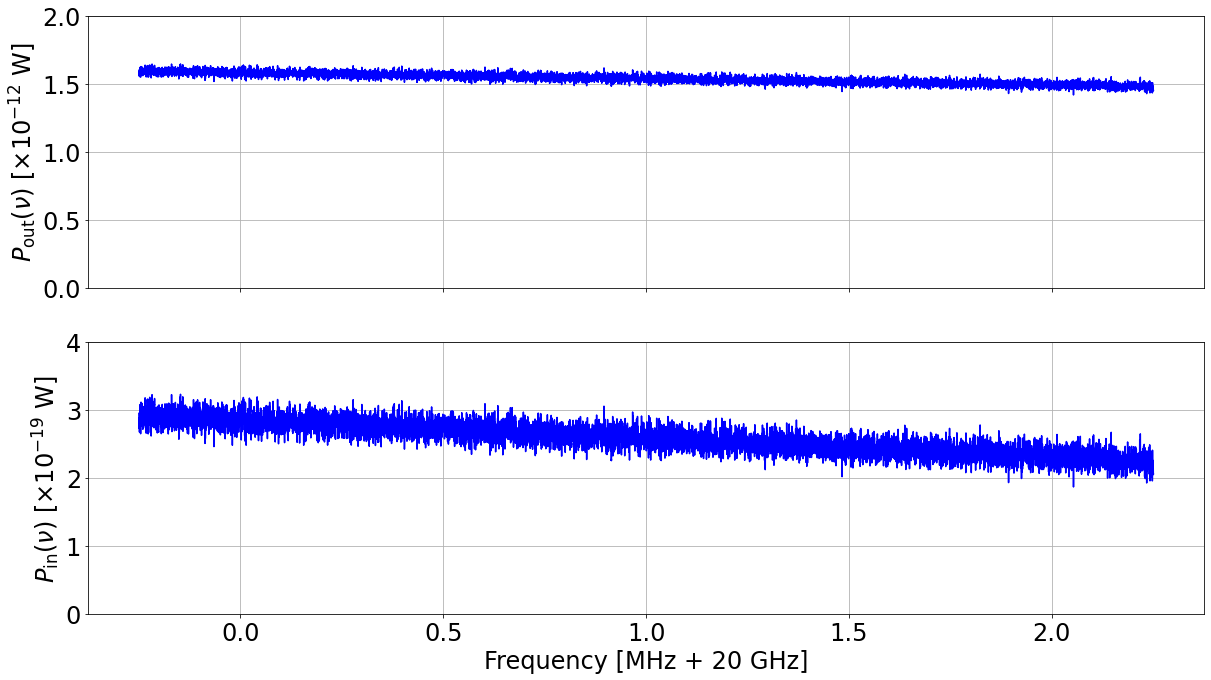

In [14]:
plt.rcParams["font.size"] = 24
fig, axes = plt.subplots(2,1,figsize=(20,11), squeeze=False, sharex=True)

path = "/data/ms2840a/signal_raw_data/scan_FFT_19.999750GHz_span2.50MHz_rbw0.3kHz_2.0sec_1counts_12runs"
Watt = []
for i in range(12):
    Watt.append(func.dat_to_array(path + "_{}.dat".format(i))[1])
    freq = func.dat_to_array(path + "_{}.dat".format(i))[0]
    
W = np.zeros(0)
for i in range(len(Watt[0])):
    W = np.append(W, np.mean(np.array([Watt[j][i] for j in range(12)])))

ax = axes[0][0]
ax.plot((freq/1e9-20)*1e3, W*1e12, color="blue")
ax.grid()
ax.set_ylim([0,2])
#ax.set_yticks([-90,-85,-80])
ax.set_ylabel(r"$P_{\rm out}(\nu) ~[\times 10^{-12} ~\rm W]$")


path = "/data/ms2840a/result_data/signal_12_data/start_19.999750GHz.csv"
Watt = []
for i in range(12):
    Watt.append(func.csv_to_array(path)["W_{}".format(i)])
    freq = func.csv_to_array(path)["freq"]
    
W = np.zeros(0)
for i in range(len(Watt[0])):
    W = np.append(W, np.mean(np.array([Watt[j][i] for j in range(12)])))


ax = axes[1][0]
ax.plot((freq/1e9-20)*1e3, W*1e19, color="blue")
ax.set_ylim([0,4])
#ax.set_yticks([-160,-155,-150])
ax.set_ylabel(r"$P_{\rm in}(\nu) ~[\times 10^{-19} ~\rm W]$")
ax.set_xlabel("Frequency [MHz + 20 GHz]")
ax.grid()

plt.savefig("../result_figure/fit_result/raw_data.pdf")

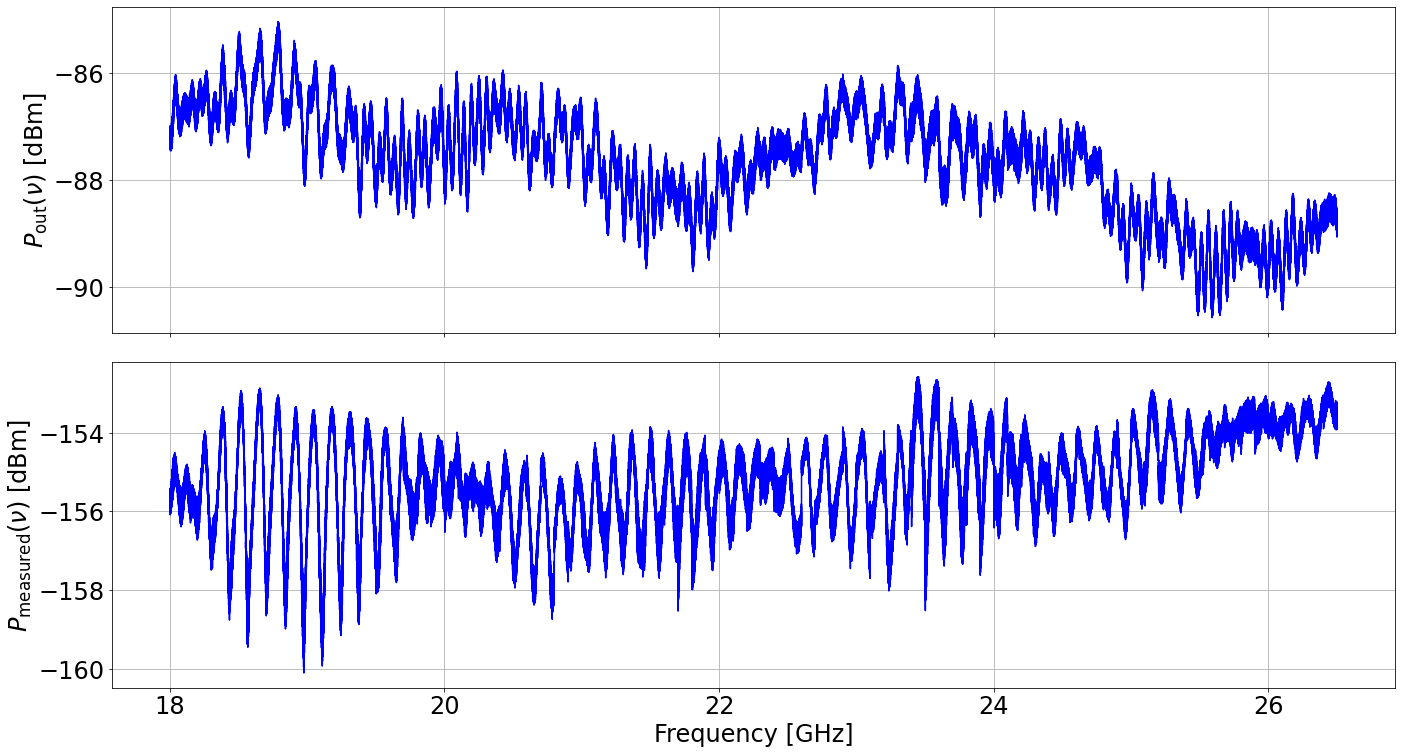

In [5]:
plt.rcParams["font.size"] = 24
fig, axes = plt.subplots(2,1,figsize=(20,11), squeeze=False, sharex=True)
#fig.suptitle("Result of Exp.1 ~ Exp.4")

ax = axes[0][0]

ax.plot(data1["freq"], np.log10(data1["W"]*1000)*10, color="blue")
ax.grid()
ax.set_ylabel(r"$P_{\rm out}(\nu)$ [dBm]")

ax = axes[1][0]

ax.plot(data2["freq"]/1e9, np.log10(data2["W_mean"]*1000)*10, color="blue")
ax.grid()
ax.set_ylabel(r"$P_{\rm measured}(\nu)$ [dBm]")
ax.set_xlabel("Frequency [GHz]")
                    
fig.tight_layout()

plt.savefig("../result_figure/fit_result/raw_data.pdf")

In [2]:
def p_glob(x):
    return 1-(1-x)**(4.25e6*0.38)

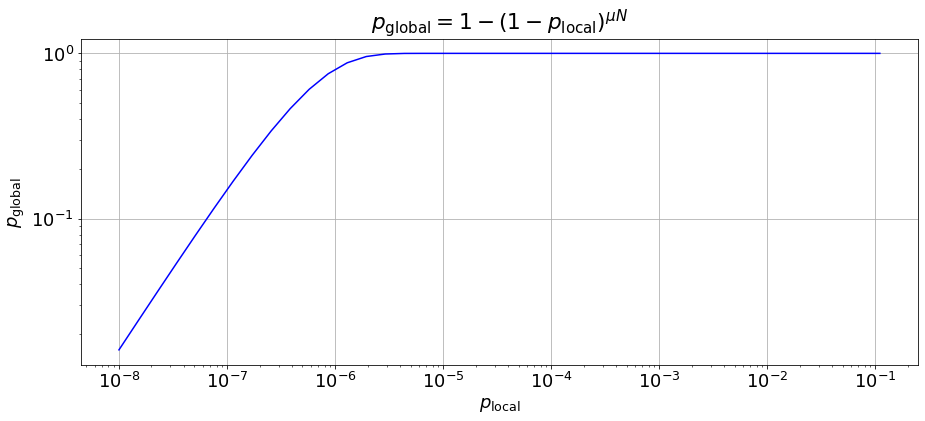

In [11]:
x = np.array([1e-8])
while x[-1] < 0.1:
    xx = x[-1]*1.5
    x = np.append(x, xx)

plt.figure(figsize=(15,6))
plt.rcParams["font.size"] = 18
plt.plot(x, p_glob(x), color="blue")
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$p_{\rm local}$")
plt.ylabel(r"$p_{\rm global}$")
plt.title(r"$p_{\rm global} = 1 - (1 - p_{\rm local})^{\mu N}$")
plt.grid()
plt.savefig("../result_figure/N_eff/p_global.pdf")